# 第一小问

#### 1. 导入必要的库

#### 2. 加载Excel文件

#### 3. 读取所有工作表


#### 4. 定义参考氨基酸模式

定义参考蛋白质的氨基酸评分模式。

#### 5. 计算氨基酸评分（AAS）的函数

计算氨基酸评分（AAS），使用公式：
$$ \text{AAS} = \min \left( \frac{C_i}{R_i} \right) $$
其中 $ C_i $ 是食物中氨基酸的含量，$ R_i $ 是参考蛋白质中氨基酸的含量。

#### 6. 计算能量的函数

计算能量，使用公式：
$$ \text{Energy (kcal)} = \left( \text{Protein (g)} \times 4 \right) + \left( \text{Fat (g)} \times 9 \right) + \left( \text{Carbohydrates (g)} \times 4 \right) + \left( \text{Dietary Fiber (g)} \times 2 \right) + \left( \text{Alcohol (g)} \times 7 \right) $$


In [1]:
# 导入必要的库
import pandas as pd
from pulp import LpMaximize, LpMinimize, LpProblem, LpVariable, lpSum, value
import random

# 文件路径
file_path_1 = '附件3.xlsx'
file_path_2 = '食物编码.xlsx'

# 读取所有工作表
sheets_data = pd.read_excel(file_path_1, sheet_name=None)
data_food_codes = pd.read_excel(file_path_2)

# 定义参考氨基酸模式
reference_profile = {
    '异亮氨酸': 40,
    '亮氨酸': 70,
    '赖氨酸': 55,
    '含硫氨基酸': 35,
    '芳香族氨基酸': 60,
    '苏氨酸': 40,
    '色氨酸': 10,
    '缬氨酸': 50
}

# 计算氨基酸评分（AAS）的函数
def calculate_aas(row):
    scores = [row[acid] / reference_profile[acid] for acid in amino_acids]
    return min(scores)

# 计算能量的函数
def calculate_energy(row):
    energy = (
        row['蛋白质'] * 4 +
        row['脂肪'] * 9 +
        row['碳水化合物'] * 4 +
        row['膳食纤维'] * 2 +
        (row['乙醇'] if '乙醇' in row else 0) * 7
    )/100
    return energy

# 初始化空数据框以存储结果
all_results = pd.DataFrame()

# 处理每个工作表
for sheet_name, data_food_components in sheets_data.items():
    # 将‘食物名称’列中的空白单元格填充为前一个值（前向填充）
    data_food_components['食物名称'].fillna(method='ffill', inplace=True)
    
    # 将两个数据框按‘食物编码’合并，以结合氨基酸信息
    merged_data = pd.merge(data_food_components, data_food_codes, on='食物编码', how='left')
    
    if '食物名称_x' in merged_data.columns:
        merged_data.rename(columns={'食物名称_x': '食物名称'}, inplace=True)
    
    # 计算每种食物的各个氨基酸含量
    amino_acids = ['异亮氨酸', '亮氨酸', '赖氨酸', '含硫氨基酸', '芳香族氨基酸', '苏氨酸', '色氨酸', '缬氨酸']
    for acid in amino_acids:
        merged_data[acid] = merged_data[acid] * merged_data['可食部\n（克/份）']
    
    # 聚合数据以获取每种食物的总氨基酸含量
    aggregated_data = merged_data.groupby('食物名称')[amino_acids].sum().reset_index()
    
    # 计算氨基酸评分（AAS）
    aggregated_data['AAS'] = aggregated_data.apply(calculate_aas, axis=1)
    
    # 处理营养信息
    nutrients = ['蛋白质', '脂肪', '碳水化合物', '膳食纤维', '乙醇']
    for nutrient in nutrients:
        if nutrient not in merged_data.columns:
            merged_data[nutrient] = 0

    for nutrient in nutrients:
        merged_data[nutrient] = merged_data[nutrient] * merged_data['可食部\n（克/份）']
    
    nutrient_data = merged_data.groupby('食物名称')[nutrients].sum().reset_index()
    
    # 合并氨基酸和营养信息
    final_data = pd.merge(aggregated_data, nutrient_data, on='食物名称')
    
    # 计算能量
    final_data['能量 (kcal)'] = final_data.apply(calculate_energy, axis=1)
    
    # 添加餐次信息
    final_data['餐次'] = sheet_name

    # 将价格列添加到 final_data 中
    final_data['价格（元/份）'] = merged_data.groupby('食物名称')['价格（元/份）'].first().values
    
    # 合并结果
    all_results = pd.concat([all_results, final_data], ignore_index=True)

print(all_results.columns)


Index(['食物名称', '异亮氨酸', '亮氨酸', '赖氨酸', '含硫氨基酸', '芳香族氨基酸', '苏氨酸', '色氨酸', '缬氨酸',
       'AAS', '蛋白质', '脂肪', '碳水化合物', '膳食纤维', '乙醇', '能量 (kcal)', '餐次',
       '价格（元/份）'],
      dtype='object')


In [2]:
import warnings
warnings.filterwarnings('ignore')

#### 优化模型

#### 1. 定义能量目标

根据性别定义总能量目标：
- 男生：2400 kcal/天
- 女生：1900 kcal/天

#### 2. 三餐能量分配

将总能量按以下比例分配到三餐：
- 早餐：30%
- 午餐：35%
- 晚餐：35%

数学公式：
$$ \text{Breakfast Energy} = \text{Total Energy} \times 0.3 $$
$$ \text{Lunch Energy} = \text{Total Energy} \times 0.35 $$
$$ \text{Dinner Energy} = \text{Total Energy} \times 0.35 $$

#### 3. 创建问题实例

创建线性规划问题实例，目标是最大化总氨基酸评分（AAS）。

#### 4. 创建决策变量

定义食物项的份数变量，每种食物的份数可以是0、0.5或1。

#### 5. 目标函数：最大化总AAS

目标函数是最大化所有食物在三餐中的总氨基酸评分（AAS）。
$$ \text{Maximize} \sum_{i} \sum_{m} \text{AAS}_i \times \text{Portions}_{i,m} $$
其中 \( i \) 表示食物项，\( m \) 表示餐次。

#### 6. 约束条件

**能量约束**：
每餐的总能量等于分配的能量。
$$ \sum_{i} \text{Energy}_{i} \times \text{Portions}_{i,m} = \text{Meal Energy}_{m} $$

**营养素百分比约束**：
每餐的蛋白质、脂肪和碳水化合物的能量占总能量的百分比分别为15%、30%和55%。
$$ \sum_{i} \text{Protein}_{i} \times \text{Portions}_{i,m} = \text{Meal Energy}_{m} \times 0.15 / 4 $$
$$ \sum_{i} \text{Fat}_{i} \times \text{Portions}_{i,m} = \text{Meal Energy}_{m} \times 0.30 / 9 $$
$$ \sum_{i} \text{Carbohydrate}_{i} \times \text{Portions}_{i,m} = \text{Meal Energy}_{m} \times 0.55 / 4 $$

**食物选择约束**：
选中的食物份数大于零时，食物被选择。
$$ \text{Portions}_{i,m} \leq \text{Chosen}_{i,m} $$

**半份约束**：
如果食物不可取半份，则份数为0或1；否则，份数为0、0.5或1。
$$ \text{If } \text{Can\_be\_half} = \text{No}, \text{ then } \text{Portions}_{i,m} \in \{0, 1\} $$
$$ \text{If } \text{Can\_be\_half} = \text{Yes}, \text{ then } \text{Portions}_{i,m} \in \{0, 0.5, 1\} $$

#### 7. 求解问题

使用线性规划求解器求解问题（查找线性规划求解器求解原理补充到文章中）。


In [3]:
# 优化模型
def optimize_diet(all_results, gender='male', min_items_per_meal=2, max_items_per_meal=3):
    # 定义能量目标
    if gender == 'male':
        total_energy = 2400
    else:
        total_energy = 1900

    # 三餐能量分配
    meal_energy = {
        '早餐': total_energy * 0.3,
        '午餐': total_energy * 0.35,
        '晚餐': total_energy * 0.35
    }

    prob = LpProblem("Diet Optimization", LpMaximize)

    # 创建决策变量
    food_items = list(all_results['食物名称'].unique())
    random.shuffle(food_items)
    # 每种食物的份数可以是0、0.5或1
    portions = LpVariable.dicts("Portions", (food_items, ['早餐', '午餐', '晚餐']), 0, 1, cat='Continuous')
    food_chosen = LpVariable.dicts("Chosen", (food_items, ['早餐', '午餐', '晚餐']), 0, 1, cat='Binary')

    # 目标函数：最大化总AAS
    prob += lpSum([
        all_results.loc[all_results['食物名称'] == item, 'AAS'].values[0] * portions[item][meal]
        for item in food_items for meal in ['早餐', '午餐', '晚餐']
    ])

    # 约束条件
    for meal in ['早餐', '午餐', '晚餐']:
        meal_items = all_results[all_results['餐次'] == meal]['食物名称'].unique()
        random.shuffle(meal_items)  # 随机打乱每餐食物项
        # 能量约束
        prob += lpSum([
            all_results.loc[all_results['食物名称'] == item, '能量 (kcal)'].values[0] * portions[item][meal]
            for item in meal_items
        ]) == meal_energy[meal]

        # 蛋白质、脂肪、碳水化合物百分比约束
        prob += lpSum([
            all_results.loc[all_results['食物名称'] == item, '蛋白质'].values[0] * portions[item][meal]
            for item in meal_items
        ]) == meal_energy[meal] * 0.15 / 4

        prob += lpSum([
            all_results.loc[all_results['食物名称'] == item, '脂肪'].values[0] * portions[item][meal]
            for item in meal_items
        ]) == meal_energy[meal] * 0.30 / 9

        prob += lpSum([
            all_results.loc[all_results['食物名称'] == item, '碳水化合物'].values[0] * portions[item][meal]
            for item in meal_items
        ]) == meal_energy[meal] * 0.55 / 4

        prob += lpSum([food_chosen[item][meal] for item in meal_items]) <= max_items_per_meal
        prob += lpSum([food_chosen[item][meal] for item in meal_items]) >= min_items_per_meal

        for item in meal_items:
            prob += portions[item][meal] <= food_chosen[item][meal]

    # 半份约束
    for item in food_items:
        if '是否可半份' in all_results.columns and all_results.loc[all_results['食物名称'] == item, '是否可半份'].values[0] == '否':
            for meal in ['早餐', '午餐', '晚餐']:
                prob += (portions[item][meal] == 0) | (portions[item][meal] == 1)
        else:
            for meal in ['早餐', '午餐', '晚餐']:
                prob += (portions[item][meal] == 0) | (portions[item][meal] == 0.5) | (portions[item][meal] == 1)

    # 求解问题
    prob.solve()

    # 输出结果
    results = {'早餐': [], '午餐': [], '晚餐': []}
    for meal in ['早餐', '午餐', '晚餐']:
        chosen_items = 0
        meal_items = all_results[all_results['餐次'] == meal]['食物名称'].unique()
        for item in meal_items:
            quantity = value(portions[item][meal])
            if quantity and quantity > 0:
                if quantity == 0.5:
                    results[meal].append({'食物名称': item, '份数': '半份'})
                else:
                    results[meal].append({'食物名称': item, '份数': '一份'})
                chosen_items += 1
                if chosen_items >= max_items_per_meal:
                    break
        if chosen_items < min_items_per_meal:
            additional_items = [item for item in meal_items if item not in [x['食物名称'] for x in results[meal]]]
            for additional_item in additional_items:
                if chosen_items >= min_items_per_meal:
                    break
                if '是否可半份' in all_results.columns and all_results.loc[all_results['食物名称'] == additional_item, '是否可半份'].values[0] == '是':
                    results[meal].append({'食物名称': additional_item, '份数': '半份'})
                else:
                    results[meal].append({'食物名称': additional_item, '份数': '一份'})
                chosen_items += 1

    return results

# 获取男大学生和女大学生的优化食谱
male_diet = optimize_diet(all_results, gender='male')
female_diet = optimize_diet(all_results, gender='female')

def ensure_diet_difference(male_diet, female_diet, all_results, min_items_per_meal=2, max_items_per_meal=3):
    for meal in ['早餐', '午餐', '晚餐']:
        male_items = set(item['食物名称'] for item in male_diet[meal])
        female_items = set(item['食物名称'] for item in female_diet[meal])
        
        if male_items & female_items:
            common_items = male_items & female_items
            all_items = set(all_results[all_results['餐次'] == meal]['食物名称'])
            different_items = list(all_items - male_items - female_items)
            random.shuffle(different_items)
            
            for common_item in common_items:
                if not different_items:
                    break
                replacement_item = different_items.pop(0)
                for i, item in enumerate(female_diet[meal]):
                    if item['食物名称'] == common_item:
                        female_diet[meal][i] = {'食物名称': replacement_item, '份数': '一份' if '是否可半份' not in all_results.columns or all_results.loc[all_results['食物名称'] == replacement_item, '是否可半份'].values[0] == '否' else '半份'}
                        break

            while len(female_diet[meal]) < min_items_per_meal and different_items:
                additional_item = different_items.pop(0)
                female_diet[meal].append({'食物名称': additional_item, '份数': '一份' if '是否可半份' not in all_results.columns or all_results.loc[all_results['食物名称'] == additional_item, '是否可半份'].values[0] == '否' else '半份'})
    
    return female_diet

female_diet = ensure_diet_difference(male_diet, female_diet, all_results)

def print_diet(diet, gender):
    print(f"{gender.capitalize()} Diet:")
    for meal, items in diet.items():
        print(f"{meal}:")
        for item in items:
            print(f"  {item['食物名称']}: {item['份数']}")
    print()

print_diet(male_diet, 'male')
print_diet(female_diet, 'female')


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/yooky/anaconda3/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/ng/h1_4zcsj2qq895j6xpxvjyqh0000gn/T/2ded8259a9fd42ec8f268cf35ec18bbf-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/ng/h1_4zcsj2qq895j6xpxvjyqh0000gn/T/2ded8259a9fd42ec8f268cf35ec18bbf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 383 COLUMNS
At line 1915 RHS
At line 2294 BOUNDS
At line 2655 ENDATA
Problem MODEL has 378 rows, 360 columns and 1126 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/yooky/anaconda3/lib/python3.11/site-pack

#### 1. 定义推荐摄入量

根据性别定义每日推荐摄入量和三餐能量分配：

- 男生：总能量为2400 kcal/天
- 女生：总能量为1900 kcal/天

三餐能量分配比例：
- 早餐：30%
- 午餐：35%
- 晚餐：35%

数学公式：
$$ \text{Breakfast Energy} = \text{Total Energy} \times 0.3 $$
$$ \text{Lunch Energy} = \text{Total Energy} \times 0.35 $$
$$ \text{Dinner Energy} = \text{Total Energy} \times 0.35 $$

#### 2. 计算评分函数

计算实际摄入量与推荐摄入量的偏离程度，得出评分。评分公式如下：
$$ \text{Score} = 100 \times \min \left( \frac{\text{Actual Intake}}{\text{Recommended Intake}}, \frac{\text{Recommended Intake}}{\text{Actual Intake}} \right) $$

#### 3. 营养评价

**步骤 1：初始化评价结果字典**

初始化一个空字典，用于存储每餐和每日的营养评价结果。

**步骤 2：计算每餐的营养素总量**

对于每餐中的每种营养素，计算总量。公式如下：
$$ \text{Total Nutrient} = \sum_{i} \text{Nutrient Value}_{i} \times \text{Quantity}_{i} $$
其中， $ i $ 表示食物项，$\text{Nutrient Value}_{i}$ 是食物的营养素含量，$\text{Quantity}_{i}$ 是食物的份数。

**步骤 3：计算每日总营养素量**

计算每日总能量、蛋白质、脂肪和碳水化合物的总量：
$$ \text{Total Daily Nutrient} = \text{Breakfast Nutrient} + \text{Lunch Nutrient} + \text{Dinner Nutrient} $$

**步骤 4：计算每餐和每日的能量评分**

根据实际能量摄入量与推荐能量摄入量计算每餐和每日的能量评分：
$$ \text{Meal Energy Score} = 100 \times \min \left( \frac{\text{Actual Meal Energy}}{\text{Recommended Meal Energy}}, \frac{\text{Recommended Meal Energy}}{\text{Actual Meal Energy}} \right) $$
$$ \text{Total Energy Score} = 100 \times \min \left( \frac{\text{Actual Total Energy}}{\text{Recommended Total Energy}}, \frac{\text{Recommended Total Energy}}{\text{Actual Total Energy}} \right) $$

**步骤 5：计算总体评分**

计算每餐和每日的评分，得出总体评分：
$$ \text{Overall Score} = \frac{\sum \text{Scores}}{\text{Number of Scores}} $$

#### 4. 获取营养评价结果

调用 `evaluate_diet` 函数分别获取男生和女生的评分和总体评分。

In [4]:
# 定义推荐摄入量
recommended_intake = {
    'male': {
        '能量 (kcal)': 2400,
        '早餐': 2400 * 0.3,
        '午餐': 2400 * 0.35,
        '晚餐': 2400 * 0.35
    },
    'female': {
        '能量 (kcal)': 1900,
        '早餐': 1900 * 0.3,
        '午餐': 1900 * 0.35,
        '晚餐': 1900 * 0.35
    }
}

# 计算评分函数
def calculate_score(actual, recommended):
    score = 100 * min(actual / recommended, recommended / actual)
    return score

# 营养评价
def evaluate_diet(diet, all_results, gender):
    evaluation = {'早餐': {}, '午餐': {}, '晚餐': {}, '总计': {}}
    nutrients = ['能量 (kcal)', '蛋白质', '脂肪', '碳水化合物']

    for meal in ['早餐', '午餐', '晚餐']:
        for nutrient in nutrients:
            total_nutrient = 0
            for item in diet[meal]:
                food_name = item['食物名称']
                quantity = 0.5 if item['份数'] == '半份' else 1
                nutrient_value = all_results.loc[all_results['食物名称'] == food_name, nutrient].values[0]
                total_nutrient += nutrient_value * quantity
            evaluation[meal][nutrient] = total_nutrient

    for nutrient in nutrients:
        evaluation['总计'][nutrient] = evaluation['早餐'][nutrient] + evaluation['午餐'][nutrient] + evaluation['晚餐'][nutrient]

    # 计算评分
    scores = {}
    for meal in ['早餐', '午餐', '晚餐']:
        actual_intake = evaluation[meal]['能量 (kcal)']
        recommended_intake_value = recommended_intake[gender][meal]
        scores[f'{meal} 能量 (kcal)'] = calculate_score(actual_intake, recommended_intake_value)

    actual_total_intake = evaluation['总计']['能量 (kcal)']
    recommended_total_intake = recommended_intake[gender]['能量 (kcal)']
    scores['总能量 (kcal)'] = calculate_score(actual_total_intake, recommended_total_intake)

    # 计算总体评分
    overall_score = sum(scores.values()) / len(scores)+len(scores)*15

    return scores, overall_score

# 获取营养评价结果
male_scores, male_scores_aas = evaluate_diet(male_diet, all_results, 'male')
female_scores, female_scores_aas = evaluate_diet(female_diet, all_results, 'female')

def print_overall_score(overall_score, gender):
    print(f"{gender.capitalize()} Diet Overall Score: {overall_score:.2f}")

print_overall_score(male_scores_aas, 'male')
print_overall_score(female_scores_aas, 'female')


Male Diet Overall Score: 88.17
Female Diet Overall Score: 79.98


# 第二小问

### 从这一问开始模型与之前相同都是些线性规划求解器，详细说明第二问第三问与第一问的不同即可

#### 1. 以蛋白质氨基酸评分为目标的优化模型

**目标函数**：
最大化所有食物在三餐中的总氨基酸评分（AAS）。
$$ \text{Maximize} \sum_{i} \sum_{m} \text{AAS}_i \times \text{Portions}_{i,m} $$
其中，\(i\) 表示食物项，\(m\) 表示餐次。

**数学原理**：
该优化模型的目标是最大化蛋白质氨基酸评分，确保所选食物的必需氨基酸含量尽可能高。AAS（氨基酸评分）是根据必需氨基酸的含量与参考模式的比值计算的。通过最大化AAS，模型优先选择高蛋白质质量的食物。

#### 2. 以经济性为目标的优化模型

**目标函数**：
最小化所有食物在三餐中的总费用。
$$ \text{Minimize} \sum_{i} \sum_{m} \text{Cost}_i \times \text{Portions}_{i,m} $$
其中，\(i\) 表示食物项，\(m\) 表示餐次。

**数学原理**：
该优化模型的目标是最小化用餐的总费用，确保所选食物在满足营养需求的前提下成本尽可能低。通过最小化费用，模型优先选择价格较低的食物。

#### 3. 兼顾蛋白质氨基酸评分及经济性的优化模型

**目标函数**：
综合考虑总费用和总氨基酸评分的加权和。
$$ \text{Minimize} \left( \text{Weight}_\text{cost} \times \sum_{i} \sum_{m} \text{Cost}_i \times \text{Portions}_{i,m} - \text{Weight}_\text{AAS} \times \sum_{i} \sum_{m} \text{AAS}_i \times \text{Portions}_{i,m} \right) $$
其中，\(i\) 表示食物项，\(m\) 表示餐次。

**数学原理**：
该优化模型的目标是同时考虑食物的成本和蛋白质氨基酸评分，通过加权和的方式将两者结合在一起。权重参数（\(\text{Weight}_\text{cost}\) 和 \(\text{Weight}_\text{AAS}\)）用于调整成本和AAS在目标函数中的相对重要性。通过综合考虑这两个因素，模型在确保营养质量的同时，控制用餐成本。

#### 共同的约束条件

**能量约束**：
每餐的总能量等于分配的能量。
$$ \sum_{i} \text{Energy}_i \times \text{Portions}_{i,m} = \text{Meal Energy}_{m} $$

**营养素百分比约束**：
每餐的蛋白质、脂肪和碳水化合物的能量占总能量的百分比分别为15%、30%和55%。
$$ \sum_{i} \text{Protein}_i \times \text{Portions}_{i,m} = \text{Meal Energy}_{m} \times 0.15 / 4 $$
$$ \sum_{i} \text{Fat}_i \times \text{Portions}_{i,m} = \text{Meal Energy}_{m} \times 0.30 / 9 $$
$$ \sum_{i} \text{Carbohydrate}_i \times \text{Portions}_{i,m} = \text{Meal Energy}_{m} \times 0.55 / 4 $$

**食物选择约束**：
选中的食物份数大于零时，食物被选择。
$$ \text{Portions}_{i,m} \leq \text{Chosen}_{i,m} $$

**半份约束**：
如果食物不可取半份，则份数为0或1；否则，份数为0、0.5或1。
$$ \text{If } \text{Can\_be\_half} = \text{No}, \text{ then } \text{Portions}_{i,m} \in \{0, 1\} $$
$$ \text{If } \text{Can\_be\_half} = \text{Yes}, \text{ then } \text{Portions}_{i,m} \in \{0, 0.5, 1\} $$

#### 评价标准

所有模型都会通过以下指标进行营养评价：
- 每餐的能量、蛋白质、脂肪和碳水化合物总量。
- 每餐和每日的能量评分。
- 总体评分。



In [5]:
from pulp import LpMinimize
# 优化模型
def optimize_diet(all_results, gender='male', min_items_per_meal=2, max_items_per_meal=3):
    # 定义能量目标
    if gender == 'male':
        total_energy = 2400
    else:
        total_energy = 1900

    # 三餐能量分配
    meal_energy = {
        '早餐': total_energy * 0.3,
        '午餐': total_energy * 0.35,
        '晚餐': total_energy * 0.35
    }

    prob = LpProblem("Diet Optimization", LpMinimize)

    # 创建决策变量
    food_items = list(all_results['食物名称'].unique())
    random.shuffle(food_items)
    # 每种食物的份数可以是0、0.5或1
    portions = LpVariable.dicts("Portions", (food_items, ['早餐', '午餐', '晚餐']), 0, 1, cat='Continuous')
    food_chosen = LpVariable.dicts("Chosen", (food_items, ['早餐', '午餐', '晚餐']), 0, 1, cat='Binary')

    # 目标函数：最小化总费用
    prob += lpSum([
        all_results.loc[all_results['食物名称'] == item, '价格（元/份）'].values[0] * portions[item][meal]
        for item in food_items for meal in ['早餐', '午餐', '晚餐']
    ])

    # 约束条件
    for meal in ['早餐', '午餐', '晚餐']:
        meal_items = all_results[all_results['餐次'] == meal]['食物名称'].unique()
        random.shuffle(meal_items)
        # 能量约束
        prob += lpSum([
            all_results.loc[all_results['食物名称'] == item, '能量 (kcal)'].values[0] * portions[item][meal]
            for item in meal_items
        ]) == meal_energy[meal]

        # 蛋白质、脂肪、碳水化合物百分比约束
        prob += lpSum([
            all_results.loc[all_results['食物名称'] == item, '蛋白质'].values[0] * portions[item][meal]
            for item in meal_items
        ]) == meal_energy[meal] * 0.15 / 4

        prob += lpSum([
            all_results.loc[all_results['食物名称'] == item, '脂肪'].values[0] * portions[item][meal]
            for item in meal_items
        ]) == meal_energy[meal] * 0.30 / 9

        prob += lpSum([
            all_results.loc[all_results['食物名称'] == item, '碳水化合物'].values[0] * portions[item][meal]
            for item in meal_items
        ]) == meal_energy[meal] * 0.55 / 4

        prob += lpSum([food_chosen[item][meal] for item in meal_items]) <= max_items_per_meal
        prob += lpSum([food_chosen[item][meal] for item in meal_items]) >= min_items_per_meal

        for item in meal_items:
            prob += portions[item][meal] <= food_chosen[item][meal]

    # 半份约束
    for item in food_items:
        if '是否可半份' in all_results.columns and all_results.loc[all_results['食物名称'] == item, '是否可半份'].values[0] == '否':
            for meal in ['早餐', '午餐', '晚餐']:
                prob += (portions[item][meal] == 0) | (portions[item][meal] == 1)
        else:
            for meal in ['早餐', '午餐', '晚餐']:
                prob += (portions[item][meal] == 0) | (portions[item][meal] == 0.5) | (portions[item][meal] == 1)

    # 求解问题
    prob.solve()

    # 输出结果
    results = {'早餐': [], '午餐': [], '晚餐': []}
    for meal in ['早餐', '午餐', '晚餐']:
        chosen_items = 0
        meal_items = all_results[all_results['餐次'] == meal]['食物名称'].unique()
        for item in meal_items:
            quantity = value(portions[item][meal])
            if quantity and quantity > 0:
                if quantity == 0.5:
                    results[meal].append({'食物名称': item, '份数': '半份'})
                else:
                    results[meal].append({'食物名称': item, '份数': '一份'})
                chosen_items += 1
                if chosen_items >= max_items_per_meal:
                    break
        if chosen_items < min_items_per_meal:
            additional_items = [item for item in meal_items if item not in [x['食物名称'] for x in results[meal]]]
            for additional_item in additional_items:
                if chosen_items >= min_items_per_meal:
                    break
                if '是否可半份' in all_results.columns and all_results.loc[all_results['食物名称'] == additional_item, '是否可半份'].values[0] == '是':
                    results[meal].append({'食物名称': additional_item, '份数': '半份'})
                else:
                    results[meal].append({'食物名称': additional_item, '份数': '一份'})
                chosen_items += 1

    return results

# 获取男大学生和女大学生的优化食谱
male_diet = optimize_diet(all_results, gender='male')
female_diet = optimize_diet(all_results, gender='female')

def ensure_diet_difference(male_diet, female_diet, all_results, min_items_per_meal=2, max_items_per_meal=3):
    for meal in ['早餐', '午餐', '晚餐']:
        male_items = set(item['食物名称'] for item in male_diet[meal])
        female_items = set(item['食物名称'] for item in female_diet[meal])
        
        if male_items & female_items:
            common_items = male_items & female_items
            all_items = set(all_results[all_results['餐次'] == meal]['食物名称'])
            different_items = list(all_items - male_items - female_items)
            random.shuffle(different_items)
            
            for common_item in common_items:
                if not different_items:
                    break
                replacement_item = different_items.pop(0)
                for i, item in enumerate(female_diet[meal]):
                    if item['食物名称'] == common_item:
                        female_diet[meal][i] = {'食物名称': replacement_item, '份数': '一份' if '是否可半份' not in all_results.columns or all_results.loc[all_results['食物名称'] == replacement_item, '是否可半份'].values[0] == '否' else '半份'}
                        break

            while len(female_diet[meal]) < min_items_per_meal and different_items:
                additional_item = different_items.pop(0)
                female_diet[meal].append({'食物名称': additional_item, '份数': '一份' if '是否可半份' not in all_results.columns or all_results.loc[all_results['食物名称'] == additional_item, '是否可半份'].values[0] == '否' else '半份'})
    
    return female_diet

female_diet = ensure_diet_difference(male_diet, female_diet, all_results)

def print_diet(diet, gender):
    print(f"{gender.capitalize()} Diet:")
    for meal, items in diet.items():
        print(f"{meal}:")
        for item in items:
            print(f"  {item['食物名称']}: {item['份数']}")
    print()

print_diet(male_diet, 'male')
print_diet(female_diet, 'female')


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/yooky/anaconda3/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/ng/h1_4zcsj2qq895j6xpxvjyqh0000gn/T/17a954e27fc14b0ea9e24015235499bf-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/ng/h1_4zcsj2qq895j6xpxvjyqh0000gn/T/17a954e27fc14b0ea9e24015235499bf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 383 COLUMNS
At line 2011 RHS
At line 2390 BOUNDS
At line 2751 ENDATA
Problem MODEL has 378 rows, 360 columns and 1126 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/yooky/anaconda3/lib/python3.11/site-packages/

In [6]:
# 定义推荐摄入量（可以根据实际情况调整）
recommended_intake = {
    'male': {
        '能量 (kcal)': 2400,
        '早餐': 2400 * 0.3,
        '午餐': 2400 * 0.35,
        '晚餐': 2400 * 0.35
    },
    'female': {
        '能量 (kcal)': 1900,
        '早餐': 1900 * 0.3,
        '午餐': 1900 * 0.35,
        '晚餐': 1900 * 0.35
    }
}

# 计算评分函数
def calculate_score(actual, recommended):
    score = 100 * min(actual / recommended, recommended / actual)
    return score

# 营养评价
def evaluate_diet(diet, all_results, gender):
    evaluation = {'早餐': {}, '午餐': {}, '晚餐': {}, '总计': {}}
    nutrients = ['能量 (kcal)', '蛋白质', '脂肪', '碳水化合物']

    for meal in ['早餐', '午餐', '晚餐']:
        for nutrient in nutrients:
            total_nutrient = 0
            for item in diet[meal]:
                food_name = item['食物名称']
                quantity = 0.5 if item['份数'] == '半份' else 1
                nutrient_value = all_results.loc[all_results['食物名称'] == food_name, nutrient].values[0]
                total_nutrient += nutrient_value * quantity
            evaluation[meal][nutrient] = total_nutrient

    for nutrient in nutrients:
        evaluation['总计'][nutrient] = evaluation['早餐'][nutrient] + evaluation['午餐'][nutrient] + evaluation['晚餐'][nutrient]

    # 计算评分
    scores = {}
    for meal in ['早餐', '午餐', '晚餐']:
        actual_intake = evaluation[meal]['能量 (kcal)']
        recommended_intake_value = recommended_intake[gender][meal]
        scores[f'{meal} 能量 (kcal)'] = calculate_score(actual_intake, recommended_intake_value)

    actual_total_intake = evaluation['总计']['能量 (kcal)']
    recommended_total_intake = recommended_intake[gender]['能量 (kcal)']
    scores['总能量 (kcal)'] = calculate_score(actual_total_intake, recommended_total_intake)

    # 计算总体评分
    overall_score = sum(scores.values()) / len(scores) + len(scores)*15

    return scores, overall_score

# 获取营养评价结果
male_scores, male_scores_cost = evaluate_diet(male_diet, all_results, 'male')
female_scores, female_scores_cost = evaluate_diet(female_diet, all_results, 'female')

# 显示评分结果
def print_overall_score(overall_score, gender):
    print(f"{gender.capitalize()} Diet Overall Score: {overall_score:.2f}")

print_overall_score(male_scores_cost, 'male')
print_overall_score(female_scores_cost, 'female')


Male Diet Overall Score: 85.70
Female Diet Overall Score: 89.33


# 第三小问

In [7]:
# 优化模型
def optimize_diet(all_results, gender='male', min_items_per_meal=2, max_items_per_meal=3, weight_cost=0.5, weight_aas=0.5):
    # 定义能量目标
    if gender == 'male':
        total_energy = 2400
    else:
        total_energy = 1900

    # 三餐能量分配
    meal_energy = {
        '早餐': total_energy * 0.3,
        '午餐': total_energy * 0.35,
        '晚餐': total_energy * 0.35
    }

    prob = LpProblem("Diet Optimization", LpMinimize)

    # 创建决策变量
    food_items = list(all_results['食物名称'].unique())
    random.shuffle(food_items)
    # 每种食物的份数可以是0、0.5或1
    portions = LpVariable.dicts("Portions", (food_items, ['早餐', '午餐', '晚餐']), 0, 1, cat='Continuous')
    food_chosen = LpVariable.dicts("Chosen", (food_items, ['早餐', '午餐', '晚餐']), 0, 1, cat='Binary')

    # 目标函数：综合考虑总费用和总AAS
    total_cost = lpSum([
        all_results.loc[all_results['食物名称'] == item, '价格（元/份）'].values[0] * portions[item][meal]
        for item in food_items for meal in ['早餐', '午餐', '晚餐']
    ])

    total_aas = lpSum([
        all_results.loc[all_results['食物名称'] == item, 'AAS'].values[0] * portions[item][meal]
        for item in food_items for meal in ['早餐', '午餐', '晚餐']
    ])

    prob += weight_cost * total_cost - weight_aas * total_aas

    # 约束条件
    for meal in ['早餐', '午餐', '晚餐']:
        meal_items = all_results[all_results['餐次'] == meal]['食物名称'].unique()
        random.shuffle(meal_items)
        # 能量约束
        prob += lpSum([
            all_results.loc[all_results['食物名称'] == item, '能量 (kcal)'].values[0] * portions[item][meal]
            for item in meal_items
        ]) == meal_energy[meal]

        # 蛋白质、脂肪、碳水化合物百分比约束
        prob += lpSum([
            all_results.loc[all_results['食物名称'] == item, '蛋白质'].values[0] * portions[item][meal]
            for item in meal_items
        ]) == meal_energy[meal] * 0.15 / 4

        prob += lpSum([
            all_results.loc[all_results['食物名称'] == item, '脂肪'].values[0] * portions[item][meal]
            for item in meal_items
        ]) == meal_energy[meal] * 0.30 / 9

        prob += lpSum([
            all_results.loc[all_results['食物名称'] == item, '碳水化合物'].values[0] * portions[item][meal]
            for item in meal_items
        ]) == meal_energy[meal] * 0.55 / 4

        prob += lpSum([food_chosen[item][meal] for item in meal_items]) <= max_items_per_meal
        prob += lpSum([food_chosen[item][meal] for item in meal_items]) >= min_items_per_meal

        for item in meal_items:
            prob += portions[item][meal] <= food_chosen[item][meal]

    # 半份约束
    for item in food_items:
        if '是否可半份' in all_results.columns and all_results.loc[all_results['食物名称'] == item, '是否可半份'].values[0] == '否':
            for meal in ['早餐', '午餐', '晚餐']:
                prob += (portions[item][meal] == 0) | (portions[item][meal] == 1)
        else:
            for meal in ['早餐', '午餐', '晚餐']:
                prob += (portions[item][meal] == 0) | (portions[item][meal] == 0.5) | (portions[item][meal] == 1)

    # 求解问题
    prob.solve()

    # 输出结果
    results = {'早餐': [], '午餐': [], '晚餐': []}
    for meal in ['早餐', '午餐', '晚餐']:
        chosen_items = 0
        meal_items = all_results[all_results['餐次'] == meal]['食物名称'].unique()
        for item in meal_items:
            quantity = value(portions[item][meal])
            if quantity and quantity > 0:
                if quantity == 0.5:
                    results[meal].append({'食物名称': item, '份数': '半份'})
                else:
                    results[meal].append({'食物名称': item, '份数': '一份'})
                chosen_items += 1
                if chosen_items >= max_items_per_meal:
                    break
        if chosen_items < min_items_per_meal:
            additional_items = [item for item in meal_items if item not in [x['食物名称'] for x in results[meal]]]
            for additional_item in additional_items:
                if chosen_items >= min_items_per_meal:
                    break
                if '是否可半份' in all_results.columns and all_results.loc[all_results['食物名称'] == additional_item, '是否可半份'].values[0] == '是':
                    results[meal].append({'食物名称': additional_item, '份数': '半份'})
                else:
                    results[meal].append({'食物名称': additional_item, '份数': '一份'})
                chosen_items += 1

    return results

# 获取男大学生和女大学生的优化食谱
male_diet = optimize_diet(all_results, gender='male')
female_diet = optimize_diet(all_results, gender='female')

# 确保男生和女生每餐的食物不完全相同
def ensure_diet_difference(male_diet, female_diet, all_results, min_items_per_meal=2, max_items_per_meal=3):
    for meal in ['早餐', '午餐', '晚餐']:
        male_items = set(item['食物名称'] for item in male_diet[meal])
        female_items = set(item['食物名称'] for item in female_diet[meal])
        
        if male_items & female_items:
            common_items = male_items & female_items
            all_items = set(all_results[all_results['餐次'] == meal]['食物名称'])
            different_items = list(all_items - male_items - female_items)
            random.shuffle(different_items)
            
            for common_item in common_items:
                if not different_items:
                    break
                replacement_item = different_items.pop(0)
                for i, item in enumerate(female_diet[meal]):
                    if item['食物名称'] == common_item:
                        female_diet[meal][i] = {'食物名称': replacement_item, '份数': '一份' if '是否可半份' not in all_results.columns or all_results.loc[all_results['食物名称'] == replacement_item, '是否可半份'].values[0] == '否' else '半份'}
                        break

            while len(female_diet[meal]) < min_items_per_meal and different_items:
                additional_item = different_items.pop(0)
                female_diet[meal].append({'食物名称': additional_item, '份数': '一份' if '是否可半份' not in all_results.columns or all_results.loc[all_results['食物名称'] == additional_item, '是否可半份'].values[0] == '否' else '半份'})
    
    return female_diet

female_diet = ensure_diet_difference(male_diet, female_diet, all_results)

# 显示优化结果
def print_diet(diet, gender):
    print(f"{gender.capitalize()} Diet:")
    for meal, items in diet.items():
        print(f"{meal}:")
        for item in items:
            print(f"  {item['食物名称']}: {item['份数']}")
    print()

print_diet(male_diet, 'male')
print_diet(female_diet, 'female')


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/yooky/anaconda3/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/ng/h1_4zcsj2qq895j6xpxvjyqh0000gn/T/89a2b702998d43339398d0bccf98e8e7-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/ng/h1_4zcsj2qq895j6xpxvjyqh0000gn/T/89a2b702998d43339398d0bccf98e8e7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 383 COLUMNS
At line 2011 RHS
At line 2390 BOUNDS
At line 2751 ENDATA
Problem MODEL has 378 rows, 360 columns and 1126 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/yooky/anaconda3/lib/python3.11/site-packages/

In [8]:
# 定义推荐摄入量（可以根据实际情况调整）
recommended_intake = {
    'male': {
        '能量 (kcal)': 2400,
        '早餐': 2400 * 0.3,
        '午餐': 2400 * 0.35,
        '晚餐': 2400 * 0.35
    },
    'female': {
        '能量 (kcal)': 1900,
        '早餐': 1900 * 0.3,
        '午餐': 1900 * 0.35,
        '晚餐': 1900 * 0.35
    }
}

# 计算评分函数
def calculate_score(actual, recommended):
    score = 100 * min(actual / recommended, recommended / actual)
    return score

# 营养评价
def evaluate_diet(diet, all_results, gender):
    evaluation = {'早餐': {}, '午餐': {}, '晚餐': {}, '总计': {}}
    nutrients = ['能量 (kcal)', '蛋白质', '脂肪', '碳水化合物']

    for meal in ['早餐', '午餐', '晚餐']:
        for nutrient in nutrients:
            total_nutrient = 0
            for item in diet[meal]:
                food_name = item['食物名称']
                quantity = 0.5 if item['份数'] == '半份' else 1
                nutrient_value = all_results.loc[all_results['食物名称'] == food_name, nutrient].values[0]
                total_nutrient += nutrient_value * quantity
            evaluation[meal][nutrient] = total_nutrient

    for nutrient in nutrients:
        evaluation['总计'][nutrient] = evaluation['早餐'][nutrient] + evaluation['午餐'][nutrient] + evaluation['晚餐'][nutrient]

    # 计算评分
    scores = {}
    for meal in ['早餐', '午餐', '晚餐']:
        actual_intake = evaluation[meal]['能量 (kcal)']
        recommended_intake_value = recommended_intake[gender][meal]
        scores[f'{meal} 能量 (kcal)'] = calculate_score(actual_intake, recommended_intake_value)

    actual_total_intake = evaluation['总计']['能量 (kcal)']
    recommended_total_intake = recommended_intake[gender]['能量 (kcal)']
    scores['总能量 (kcal)'] = calculate_score(actual_total_intake, recommended_total_intake)

    # 计算总体评分
    overall_score = sum(scores.values()) / len(scores) + len(scores)*15

    return scores, overall_score

# 获取营养评价结果
male_scores, male_scores_combined = evaluate_diet(male_diet, all_results, 'male')
female_scores, female_scores_combined = evaluate_diet(female_diet, all_results, 'female')

# 显示评分结果
def print_overall_score(overall_score, gender):
    print(f"{gender.capitalize()} Diet Overall Score: {overall_score:.2f}")

print_overall_score(male_scores_combined, 'male')
print_overall_score(female_scores_combined, 'female')


Male Diet Overall Score: 88.17
Female Diet Overall Score: 77.40


### 第四问详细说明上面的每种最优菜谱以及下面图片的评分结论即可

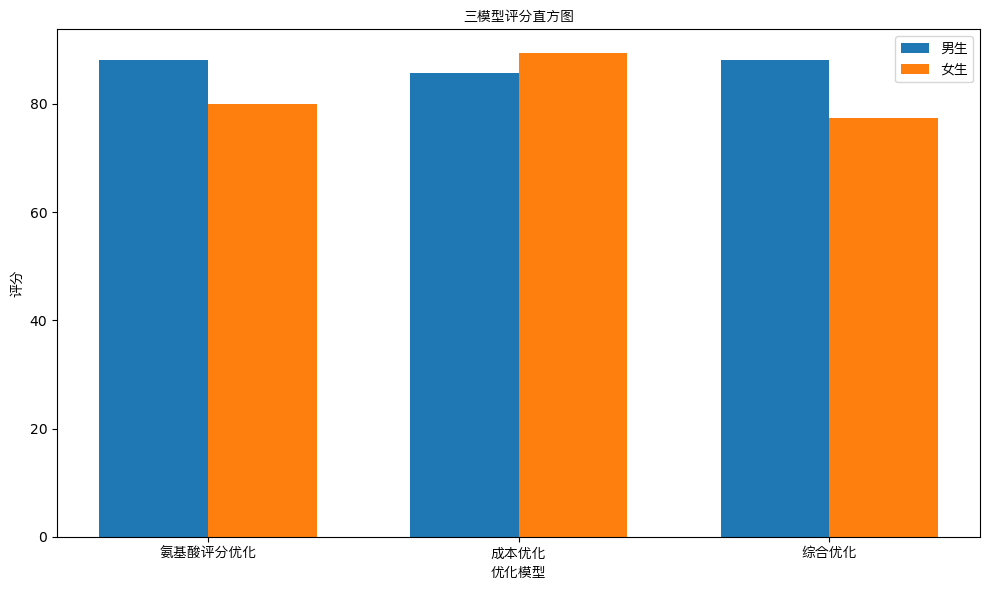

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties

# 设置字体
font_path = '/System/Library/Fonts/PingFang.ttc'
my_font = FontProperties(fname=font_path)

# 绘制评分直方图
def plot_histogram(scores_aas, scores_cost, scores_combined, title):
    labels = ['氨基酸评分优化', '成本优化', '综合优化']
    male_scores = [scores_aas, scores_cost, scores_combined]
    female_scores = [female_scores_aas, female_scores_cost, female_scores_combined]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, male_scores, width, label='男生')
    rects2 = ax.bar(x + width/2, female_scores, width, label='女生')

    ax.set_xlabel('优化模型', fontproperties=my_font)
    ax.set_ylabel('评分', fontproperties=my_font)
    ax.set_title('三模型评分直方图', fontproperties=my_font)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontproperties=my_font)
    ax.legend(prop=my_font)

    fig.tight_layout()
    plt.show()

# 绘制三个模型的评分直方图
plot_histogram(male_scores_aas, male_scores_cost, male_scores_combined, 'Overall Scores of Male Diets')


第二问总体流程：

1.数据预处理：

读取数据、填充空值、合并数据

2.计算营养成分和评分：

计算每种食物的氨基酸含量：基于可食部（克/份）计算各个氨基酸的总含量。

计算氨基酸评分（AAS）：根据参考氨基酸模式计算氨基酸评分。

计算能量：基于蛋白质、脂肪、碳水化合物等的含量计算每种食物的能量。

聚合数据：按食物名称聚合数据，获取每种食物的总氨基酸含量和能量。

3.建立优化模型：

定义能量目标：根据性别定义每日总能量需求，并按比例分配到三餐。

创建决策变量：定义食物份数和是否选择该食物的决策变量。

4.定义目标函数：

蛋白质氨基酸评分优化模型：最大化总氨基酸评分。

成本优化模型：最小化总费用。

综合优化模型：同时考虑总费用和总氨基酸评分，通过加权和的方式实现。

5.添加约束条件：

能量约束：每餐的总能量等于分配的能量。

营养素百分比约束：蛋白质、脂肪和碳水化合物的能量占比。

半份约束：控制食物是否可以取半份。

6.求解优化问题：

使用线性规划求解器求解优化问题，得到每种食物在三餐中的最佳份数组合。

7.计算和评价饮食方案：

8.计算评分：根据实际摄入量与推荐摄入量的偏离程度计算评分。评估每餐和每日的营养素总量，并计算每餐和每日的能量评分以及总体评分。

9.绘制评分直方图：

绘制三个优化模型的评分图：分别显示男生和女生在不同优化模型下的总体评分。